In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
def load_dataset():
    dataset_df1 = pd.read_csv(r"./Premonsoon/ground_water_quality_2018_pre.csv")
    dataset_df2 = pd.read_csv(r"./Premonsoon/ground_water_quality_2019_pre.csv")
    dataset_df3 = pd.read_csv(r"./Premonsoon/ground_water_quality_2020_pre .csv")
    dataset_df4 = pd.read_csv(r"./Premonsoon/ground_water_quality_2021_pre.csv")
    dataset_df5 = pd.read_csv(r"./Premonsoon/ground_water_quality_2022_pre.csv")
    dataset_df6 = pd.read_csv(r"./postmonsoon/ground_water_quality_2018_post.csv")
    dataset_df7 = pd.read_csv(r"./postmonsoon/ground_water_quality_2019_post.csv")
    dataset_df8 = pd.read_csv(r"./postmonsoon/ground_water_quality_2020_post.csv")
    dataset_df9 = pd.read_csv(r"./postmonsoon/ground_water_quality_2021_post.csv")
    dataset_df = pd.concat([dataset_df1,dataset_df2,dataset_df3,dataset_df4,dataset_df5,dataset_df6,dataset_df7,dataset_df8,dataset_df9],join='outer',ignore_index=True)
    dataset_df.drop(columns=['long_gis','lat_gis','sno','RL_GIS','sno','village','mandal','district','gwl','Classification.1','season'],inplace=True)

    dataset_df['pH'] = pd.to_numeric(dataset_df['pH'], errors='coerce')

    # Now convert to float
    dataset_df['pH'] = dataset_df['pH'].astype(float)
    dataset_df['RSC  meq  / L'] = pd.to_numeric(dataset_df['RSC  meq  / L'], errors='coerce')

    # Now convert to float
    dataset_df['RSC  meq  / L'] = dataset_df['RSC  meq  / L'].astype(float)

    temp = dataset_df['Classification'].copy()
    dataset_df['Classification'] = dataset_df['RSC  meq  / L']
    dataset_df['RSC  meq  / L'] = temp
    dataset_df = dataset_df.rename(columns={'Classification': 'RSC  meq  / L', 'RSC  meq  / L': 'Classification'})

    null_threshold = len(dataset_df) * 0.25
    for column in dataset_df.columns:
        null_count = dataset_df[column].isnull().sum()
        if null_count > null_threshold:
            dataset_df.drop(column, axis=1, inplace=True)
        elif null_count > 0:
            dataset_df.dropna(subset=[column], inplace=True)
    dataset_df.reset_index(drop=True, inplace=True)

    Classification_labels = []

    unique_labels = dataset_df['Classification'].unique()
    print(unique_labels)

    # Convert unique_labels to a set to remove duplicates and then back to a list
    Classification_labels = list(set(unique_labels))

    # Items to remove from the list
    items_to_remove = ['OG', 'BELOW THE GRAPH', 'O.G', 'OUT OF SAR GRAPH', 'BG']

    # Create a new list without the items to remove
    Classification_labels = [label for label in Classification_labels if label not in items_to_remove]

    # Filter dataset_df based on the updated Classification_labels
    dataset_df = dataset_df[dataset_df['Classification'].isin(Classification_labels)]

    dataset_df = dataset_df.reset_index(drop=True)
    print(dataset_df['Classification'].unique())
    print(dataset_df.info())
    return dataset_df

In [37]:
dataset_df = load_dataset()

['C3S1' 'C2S1' 'C3S2' 'C4S1' 'C4S2' 'C1S1' 'C4S3' 'C4S4' 'C3S3' 'OG'
 'C3S4' 'BELOW THE GRAPH' 'O.G' 'OUT OF SAR GRAPH' 'C2S2' 'BG']
['C3S1' 'C2S1' 'C3S2' 'C4S1' 'C4S2' 'C1S1' 'C4S3' 'C4S4' 'C3S3' 'C3S4'
 'C2S2']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4907 entries, 0 to 4906
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pH              4907 non-null   float64
 1   E.C             4907 non-null   float64
 2   TDS             4907 non-null   float64
 3   CO3             4907 non-null   float64
 4   HCO3            4907 non-null   float64
 5   Cl              4907 non-null   float64
 6   F               4907 non-null   float64
 7   NO3             4907 non-null   float64
 8   SO4             4907 non-null   float64
 9   Na              4907 non-null   float64
 10  K               4907 non-null   float64
 11  Ca              4907 non-null   float64
 12  Mg              4907 non-null   float64
 13  

## <b>  Random Forest Classifier </b>

In [38]:
from random import seed
from random import randrange
from math import sqrt
 

In [39]:
dataset_df['Classification'] = dataset_df['Classification'].map({'C2S1': 0, 'C3S1': 1, 'C4S2': 2, 'C4S1': 3, 'C3S2': 4
                                                                 , 'C4S4': 5, 'C4S3': 6, 'C1S1': 7, 'C3S4': 8, 'C3S3': 9, 'C2S2': 10}).astype(int)
input_X = dataset_df.drop(columns=['Classification'])
input_y = dataset_df['Classification']
print(input_y.value_counts())


Classification
1     3107
0     1169
3      238
2      148
4      112
7       52
5       26
6       25
9       23
8        6
10       1
Name: count, dtype: int64


In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_X, input_y, test_size=0.33, random_state=42)

In [41]:

class DecisionTree:
    def __init__(self, max_depth=None, max_features=None):
        self.max_depth = max_depth
        self.max_features = max_features
        self.tree = None

    def fit(self, X, y):
        self.tree = self._grow_tree(X, y, depth=0)

    def _grow_tree(self, X, y, depth):
        n_samples, n_features = X.shape
        self.n_classes = len(np.unique(y))
        n_classes = len(np.unique(y))

        # Stopping criteria
        if (depth == self.max_depth) or (n_classes == 1) or (n_samples < 2):
            return {'class': np.argmax(np.bincount(y)), 'split_feature': None, 'split_threshold': None,
                    'left': None, 'right': None}

        # Select random subset of features
        if self.max_features is not None and self.max_features < n_features:
            feature_idxs = np.random.choice(n_features, self.max_features, replace=False)
            X = X[:, feature_idxs]
        else:
            feature_idxs = np.arange(n_features)

        # Find best split
        best_gini = float('inf')
        best_split_feature, best_split_threshold = None, None
        for feature in feature_idxs:
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_idxs = X[:, feature] < threshold
                y_left = y[left_idxs]
                y_right = y[~left_idxs]
                gini = (len(y_left) / n_samples) * self._gini_impurity(y_left) + \
                       (len(y_right) / n_samples) * self._gini_impurity(y_right)
                if gini < best_gini:
                    best_gini = gini
                    best_split_feature = feature
                    best_split_threshold = threshold

        # Split the dataset
        left_idxs = X[:, best_split_feature] < best_split_threshold
        right_idxs = ~left_idxs
        if np.sum(left_idxs) == 0:
            return {'class': np.argmax(np.bincount(y[right_idxs])), 'split_feature': None, 'split_threshold': None,
                    'left': None, 'right': None}

        # Check if right subtree is empty
        if np.sum(right_idxs) == 0:
            return {'class': np.argmax(np.bincount(y[left_idxs])), 'split_feature': None, 'split_threshold': None,
                    'left': None, 'right': None}
        
        # Grow left and right subtrees
        left_subtree = self._grow_tree(X[left_idxs], y[left_idxs], depth + 1)
        right_subtree = self._grow_tree(X[right_idxs], y[right_idxs], depth + 1)

        return {'class': None, 'split_feature': best_split_feature, 'split_threshold': best_split_threshold,
                'left': left_subtree, 'right': right_subtree}

    def _gini_impurity(self, y):
        _, counts = np.unique(y, return_counts=True)
        probas = counts / len(y)
        return 1 - np.sum(probas ** 2)

    def predict(self, X):
        return np.array([self._predict_tree(x, self.tree)[0] for x in X]),np.array([self._predict_tree(x, self.tree)[1] for x in X])

    def _predict_tree(self, x, tree):
        if tree['class'] is not None:
            return tree['class'], np.eye(1, self.n_classes, tree['class'])[0]

        if x[tree['split_feature']] < tree['split_threshold']:
            class_pred, class_probs = self._predict_tree(x, tree['left'])
        else:
            class_pred, class_probs = self._predict_tree(x, tree['right'])

        return class_pred, class_probs

class RandomForest:
    def __init__(self, n_trees=100, max_depth=None, max_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        self.classes_ = 11
        for _ in range(self.n_trees):
            indices = np.random.choice(len(X), size=len(X), replace=True)
            tree = DecisionTree(max_depth=self.max_depth, max_features=self.max_features)
            tree.fit(X.iloc[indices].values, y.iloc[indices])
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.array([tree.predict(X.values)[0] for tree in self.trees])
        predictions=predictions.T
        predictions = np.array([np.bincount(pred).argmax() for pred in predictions])
        probs = np.zeros((len(X), self.classes_))
        for tree in self.trees:
            tree_probs = np.array([tree._predict_tree(x, tree.tree)[1] for x in X.values])
            if tree_probs.shape[1] < self.classes_:
                padded_probs = np.zeros((tree_probs.shape[0], self.classes_))
                padded_probs[:, :tree_probs.shape[1]] = tree_probs
                tree_probs = padded_probs
            probs += tree_probs
        probs /= self.n_trees
        return predictions,probs


In [ ]:
random_forest_acc = []
random_forest_probs = []
for i in [1, 2, 5, 10, 50 ,100]:
    rf = RandomForest(n_trees=i, max_depth=7)
    rf.fit(X_train, y_train )
    predictions,probs = rf.predict(X_test)
    random_forest_probs.append(probs)
    acc = np.sum(predictions==y_test)/len(y_test) * 100
    random_forest_acc.append(acc)

In [83]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define the range of values for max_depth
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 10, 12]  # Example range of values
}

# Initialize the XGBoost classifier
xgb = XGBClassifier(n_estimators=1)

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'max_depth': 7}
Best Score: 0.9534570420026555


In [88]:

import time

xgboost_acc = []
n_estimators_values = [1, 2, 5, 10, 50, 100]  # List of values for n_estimators

for n_estimators in n_estimators_values:
    xgb = XGBClassifier(n_estimators=n_estimators,max_depth=7,colsample_bytree=0.6)

    training_start = time.perf_counter()
    xgb.fit(X_train, y_train)
    training_end = time.perf_counter()

    prediction_start = time.perf_counter()
    preds = xgb.predict(X_test)
    prediction_end = time.perf_counter()

    acc_xgb = (preds == y_test).sum().astype(float) / len(preds) * 100
    xgboost_acc.append(acc_xgb)
    xgb_train_time = training_end - training_start
    xgb_prediction_time = prediction_end - prediction_start

    print(f"XGBoost's prediction accuracy with {n_estimators} trees: {acc_xgb:.2f}%")
    print(f"Time consumed for training with {n_estimators} trees: {xgb_train_time:.3f} seconds")
    print(f"Time consumed for prediction with {n_estimators} trees: {xgb_prediction_time:.5f} seconds")
    print()

XGBoost's prediction accuracy with 1 trees: 93.52%
Time consumed for training with 1 trees: 0.018 seconds
Time consumed for prediction with 1 trees: 0.00166 seconds

XGBoost's prediction accuracy with 2 trees: 93.83%
Time consumed for training with 2 trees: 0.017 seconds
Time consumed for prediction with 2 trees: 0.00163 seconds

XGBoost's prediction accuracy with 5 trees: 94.63%
Time consumed for training with 5 trees: 0.034 seconds
Time consumed for prediction with 5 trees: 0.00177 seconds

XGBoost's prediction accuracy with 10 trees: 94.75%
Time consumed for training with 10 trees: 0.078 seconds
Time consumed for prediction with 10 trees: 0.00262 seconds

XGBoost's prediction accuracy with 50 trees: 94.69%
Time consumed for training with 50 trees: 0.493 seconds
Time consumed for prediction with 50 trees: 0.00704 seconds

XGBoost's prediction accuracy with 100 trees: 94.63%
Time consumed for training with 100 trees: 1.144 seconds
Time consumed for prediction with 100 trees: 0.00920 s

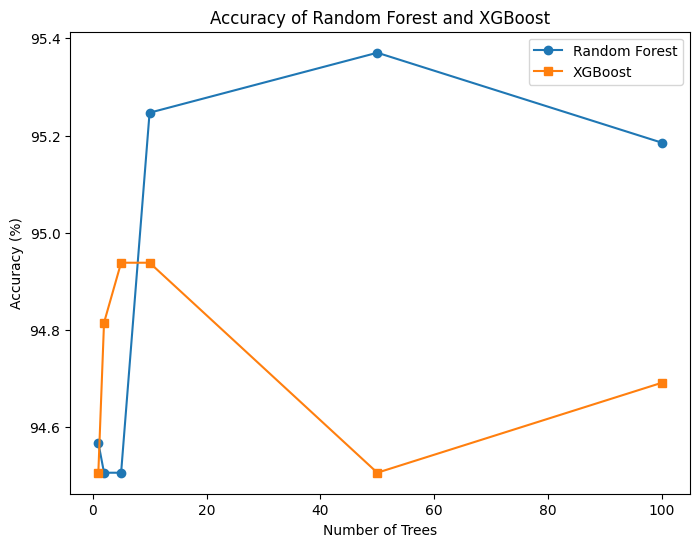

1620


In [54]:
n_estimators = [1, 2, 5, 10, 50, 100]  # Number of trees
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the data
ax.plot(n_estimators, random_forest_acc, marker='o', label='Random Forest')
ax.plot(n_estimators, xgboost_acc, marker='s', label='XGBoost')

# Set labels and title
ax.set_xlabel('Number of Trees')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy of Random Forest and XGBoost')

# Add a legend
ax.legend()

# Show the plot
plt.show()

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

sklearn_acc = []
for n_estimators in n_estimators_values:
    rf_clf = RandomForestClassifier(n_estimators, random_state=42,max_depth=7,max_features=5)

    # Train the model
    rf_clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf_clf.predict(X_test)

    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred) * 100
    sklearn_acc.append(accuracy)
    print(f"Accuracy for {n_estimators} trees : {accuracy:.2f}")

Accuracy for 1 trees : 94.57
Accuracy for 2 trees : 94.14
Accuracy for 5 trees : 95.19
Accuracy for 10 trees : 94.94
Accuracy for 50 trees : 95.74
Accuracy for 100 trees : 95.43


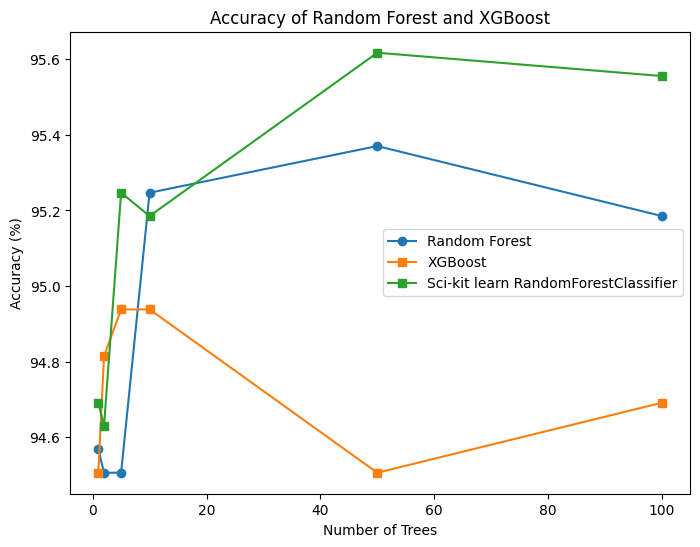

In [58]:
fig, ax = plt.subplots(figsize=(8, 6))
n_estimators = [1, 2, 5, 10, 50, 100]
# Plot the data
ax.plot(n_estimators, random_forest_acc, marker='o', label='Random Forest')
ax.plot(n_estimators, xgboost_acc, marker='s', label='XGBoost')
ax.plot(n_estimators, sklearn_acc, marker='s', label='Sci-kit learn RandomForestClassifier')

# Set labels and title
ax.set_xlabel('Number of Trees')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy of Random Forest and XGBoost')

# Add a legend
ax.legend()

# Show the plot
plt.show()